## Figure 1

Percent replicating for L1000 and Cell Painting Assays

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))

source("viz_themes.R")
source("plotting_functions.R")
source("data_functions.R")

In [2]:
output_figure_base <- file.path("figures", "figure1")
extensions <- c(".png", ".pdf")

### Panel A - Within assay percent replicating

In [3]:
results_dir <- file.path("../1.Data-exploration/Profiles_level4/results")

In [4]:
cell_painting_pr_df <- load_percent_replicating(assay = "cellpainting", results_dir = results_dir)
l1000_pr_df <- load_percent_replicating(assay = "l1000", results_dir = results_dir)

pr_df <- dplyr::bind_rows(cell_painting_pr_df, l1000_pr_df)
pr_df$dose <- factor(pr_df$dose, levels = dose_order)

print(dim(pr_df))
head(pr_df)

[1] 63528     4


dose,replicate_correlation,type,assay
<fct>,<dbl>,<chr>,<chr>
0.04 uM,0.06065485,replicate,Cell Painting
0.12 uM,0.03517204,replicate,Cell Painting
0.37 uM,0.06197959,replicate,Cell Painting
1.11 uM,0.07803886,replicate,Cell Painting
3.33 uM,0.14604623,replicate,Cell Painting
10 uM,0.47583989,replicate,Cell Painting


In [5]:
print(dim(cell_painting_pr_df))
print(dim(l1000_pr_df))

[1] 31548     4
[1] 31980     4


In [6]:
threshold_df <- pr_df %>%
    dplyr::filter(type == 'non_replicate') %>%
    dplyr::group_by(assay, dose) %>%
    dplyr::summarise(threshold = quantile(replicate_correlation, 0.95))

percent_replicating_df <- pr_df %>%
    dplyr::left_join(threshold_df, by = c("assay", "dose")) %>%
    dplyr::filter(type == "replicate") %>%
    dplyr::mutate(pass_threshold = threshold < replicate_correlation) %>%
    dplyr::group_by(dose, assay) %>%
    dplyr::summarize(percent_replicating = paste0(100 * round((sum(pass_threshold) / length(pass_threshold)), 4), "%")) %>%
    dplyr::ungroup()

percent_replicating_df

dose,assay,percent_replicating
<fct>,<chr>,<chr>
0.04 uM,Cell Painting,53.18%
0.04 uM,L1000,26.47%
0.12 uM,Cell Painting,58.51%
0.12 uM,L1000,23.98%
0.37 uM,Cell Painting,60.41%
0.37 uM,L1000,28.35%
1.11 uM,Cell Painting,63.59%
1.11 uM,L1000,35.19%
3.33 uM,Cell Painting,68.92%


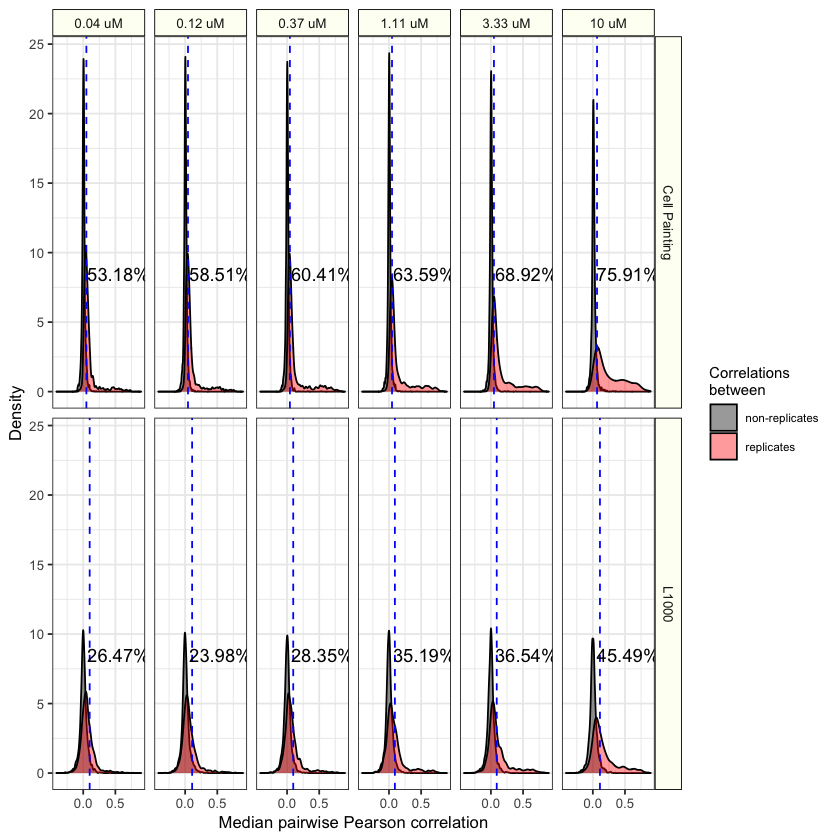

In [7]:
panel_a_gg <- (
    ggplot(pr_df, aes(x = replicate_correlation))
    + geom_density(aes(fill = type), alpha = 0.4)
    + facet_grid("assay~dose")
    + geom_vline(data = threshold_df, linetype = "dashed", color = "blue", aes(xintercept=threshold))
    + geom_text(data = percent_replicating_df, aes(label = percent_replicating, x = 0.55, y = 8.5))
    + theme_bw()
    + figure_theme
    + scale_fill_manual("Correlations\nbetween", labels = replicate_labels, values = replicate_colors)
    + xlab("Median pairwise Pearson correlation")
    + ylab("Density")
)

panel_a_gg

## Panel B - Comparing percent replicating scores

At the perturbation level between the two assays.

In [8]:
# First, obtain the threshold to consider strong phenotype
cell_painting_pr_df <- load_percent_replicating(assay = "cellpainting", results_dir = results_dir)
l1000_pr_df <- load_percent_replicating(assay = "l1000", results_dir = results_dir)

pr_df <- dplyr::bind_rows(cell_painting_pr_df, l1000_pr_df)
pr_df$dose <- factor(pr_df$dose, levels = dose_order)

threshold_df <- pr_df %>%
    dplyr::filter(type == 'non_replicate') %>%
    dplyr::group_by(assay, dose) %>%
    dplyr::summarise(threshold = quantile(replicate_correlation, 0.95))

threshold_plot_ready_df <- threshold_df %>% reshape2::dcast(dose ~ assay, value.var = "threshold")

In [9]:
# Next, get the median scores and determine if they pass the threshold
cell_painting_comp_df <- load_median_correlation_scores(assay = "cellpainting", results_dir = results_dir)
l1000_comp_df <- load_median_correlation_scores(assay = "l1000", results_dir = results_dir)

significant_compounds_df <- cell_painting_comp_df %>%
    dplyr::left_join(l1000_comp_df, by = c("dose", "compound"), suffix = c("_cellpainting", "_l1000")) %>%
    tidyr::drop_na() %>%
    dplyr::left_join(threshold_df %>% dplyr::filter(assay == "Cell Painting"), by = "dose") %>%
    dplyr::left_join(threshold_df %>% dplyr::filter(assay == "L1000"), by = "dose", suffix = c("_cellpainting", "_l1000")) %>%
    dplyr::mutate(
        pass_cellpainting_thresh = median_replicate_score_cellpainting > threshold_cellpainting,
        pass_l1000_thresh = median_replicate_score_l1000 > threshold_l1000
    ) %>%
    dplyr::mutate(pass_both = pass_cellpainting_thresh + pass_l1000_thresh) %>%
    dplyr::mutate(pass_both = ifelse(pass_both == 2, TRUE, FALSE)) %>%
    dplyr::select(compound, dose, median_replicate_score_cellpainting, median_replicate_score_l1000, pass_cellpainting_thresh, pass_l1000_thresh, pass_both)

# Count in how many doses the particular compound was reproducible
cp_reprod_count_df <- significant_compounds_df %>%
    dplyr::filter(pass_cellpainting_thresh) %>%
    dplyr::group_by(compound) %>%
    dplyr::count() %>%
    dplyr::rename(cell_painting_num_reproducible = n)

l1000_reprod_count_df <- significant_compounds_df %>%
    dplyr::filter(pass_l1000_thresh) %>%
    dplyr::group_by(compound) %>%
    dplyr::count() %>%
    dplyr::rename(l1000_num_reproducible = n)

significant_compounds_df <- significant_compounds_df %>%
    dplyr::left_join(cp_reprod_count_df, by = "compound") %>%
    dplyr::left_join(l1000_reprod_count_df, by = "compound") %>%
    tidyr::replace_na(list(l1000_num_reproducible = 0, cell_painting_num_reproducible = 0)) %>%
    dplyr::mutate(total_reproducible = cell_painting_num_reproducible + l1000_num_reproducible)

significant_compounds_df$dose <- factor(significant_compounds_df$dose, levels = dose_order)
significant_compounds_df$compound <- tolower(significant_compounds_df$compound)

# Output file for further use
output_file <- file.path("data", "significant_compounds_by_threshold_both_assays.tsv.gz")
significant_compounds_df %>% readr::write_tsv(output_file)

print(dim(significant_compounds_df))
head(significant_compounds_df, 3)

Warning message:
“Column `dose` joining character vector and factor, coercing into character vector”
Warning message:
“Column `dose` joining character vector and factor, coercing into character vector”


[1] 7962   10


compound,dose,median_replicate_score_cellpainting,median_replicate_score_l1000,pass_cellpainting_thresh,pass_l1000_thresh,pass_both,cell_painting_num_reproducible,l1000_num_reproducible,total_reproducible
<chr>,<fct>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>
17-hydroxyprogesterone-caproate,0.04 uM,0.06065485,0.02473778,TRUE,FALSE,FALSE,5,3,8
2-iminobiotin,0.04 uM,0.04270010,-0.13369283,FALSE,FALSE,FALSE,0,2,2
3-amino-benzamide,0.04 uM,0.10427276,0.05195868,TRUE,FALSE,FALSE,5,1,6


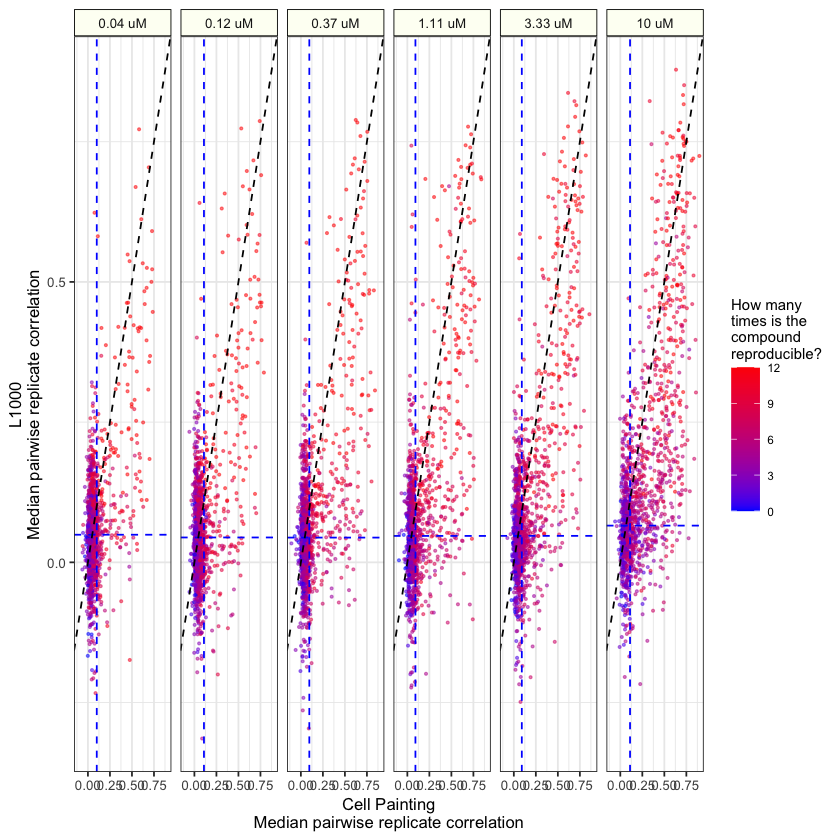

In [10]:
panel_b_gg <- (
    ggplot(significant_compounds_df, aes(x = median_replicate_score_cellpainting, y = median_replicate_score_l1000))
    + geom_point(aes(color = total_reproducible), size = 0.5, alpha = 0.5)
    + facet_grid("~dose")
    + geom_hline(data = threshold_plot_ready_df, aes(yintercept = `Cell Painting`), linetype = "dashed", color = "blue")
    + geom_vline(data = threshold_plot_ready_df, aes(xintercept = L1000), linetype = "dashed", color = "blue")
    + geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "black")
    + figure_theme
    + scale_color_gradient("How many\ntimes is the \ncompound\nreproducible?", low = "blue", high = "red")
    + xlab("Cell Painting\nMedian pairwise replicate correlation")
    + ylab("L1000\nMedian pairwise replicate correlation")
)

panel_b_gg

## Panel C - Percent replicating summary

Which compounds pass the null distribution threshold?

In [11]:
cell_painting_comp_df <- load_median_correlation_scores(assay = "cellpainting", results_dir = results_dir)
l1000_comp_df <- load_median_correlation_scores(assay = "l1000", results_dir = results_dir)

significant_compounds_df <- cell_painting_comp_df %>%
    dplyr::left_join(l1000_comp_df, by = c("dose", "compound"), suffix = c("_cellpainting", "_l1000")) %>%
    tidyr::drop_na() %>%
    dplyr::left_join(threshold_df %>% dplyr::filter(assay == "Cell Painting"), by = "dose") %>%
    dplyr::left_join(threshold_df %>% dplyr::filter(assay == "L1000"), by = "dose", suffix = c("_cellpainting", "_l1000")) %>%
    dplyr::mutate(
        pass_cellpainting_thresh = median_replicate_score_cellpainting > threshold_cellpainting,
        pass_l1000_thresh = median_replicate_score_l1000 > threshold_l1000
    ) %>%
    dplyr::select(compound, dose, pass_cellpainting_thresh, pass_l1000_thresh) %>%
    dplyr::mutate(pass_both = pass_cellpainting_thresh + pass_l1000_thresh) %>%
    dplyr::mutate(pass_both = ifelse(pass_both == 2, TRUE, FALSE))

total_compounds <- length(unique(significant_compounds_df$compound))
total_compounds

head(significant_compounds_df, 3)

Warning message:
“Column `dose` joining character vector and factor, coercing into character vector”
Warning message:
“Column `dose` joining character vector and factor, coercing into character vector”


[1] 1327

compound,dose,pass_cellpainting_thresh,pass_l1000_thresh,pass_both
<chr>,<chr>,<lgl>,<lgl>,<lgl>
17-hydroxyprogesterone-caproate,0.04 uM,TRUE,FALSE,FALSE
2-iminobiotin,0.04 uM,FALSE,FALSE,FALSE
3-amino-benzamide,0.04 uM,TRUE,FALSE,FALSE


In [12]:
pass_thresh_summary_df <- significant_compounds_df %>%
    dplyr::group_by(dose) %>%
    dplyr::mutate(
        num_pass_cellpainting = sum(pass_cellpainting_thresh),
        num_pass_l1000 = sum(pass_l1000_thresh),
        num_pass_both = sum(pass_both)
    ) %>%
    dplyr::ungroup() %>%
    dplyr::select(dose, num_pass_cellpainting, num_pass_l1000, num_pass_both) %>%
    dplyr::distinct() %>%
    dplyr::mutate(
        unique_pass_cellpainting = num_pass_cellpainting - num_pass_both,
        unique_pass_l1000 = num_pass_l1000 - num_pass_both
    )

pass_thresh_summary_df

dose,num_pass_cellpainting,num_pass_l1000,num_pass_both,unique_pass_cellpainting,unique_pass_l1000
<chr>,<int>,<int>,<int>,<int>,<int>
0.04 uM,707,350,239,468,111
0.12 uM,782,317,216,566,101
0.37 uM,807,376,286,521,90
1.11 uM,850,467,349,501,118
3.33 uM,921,485,403,518,82
10 uM,1015,604,547,468,57


In [13]:
# Prep data and text for plotting
cell_painting_rect <- pass_thresh_summary_df %>%
    dplyr::select(dose, num_pass_cellpainting, unique_pass_cellpainting, num_pass_both) %>%
    dplyr::rename(c(ymax_bar = num_pass_cellpainting, unique_pass = unique_pass_cellpainting)) %>%
    dplyr::mutate(
        ymin_bar = 0,
        xmin_bar = seq(0, (length(unique(pass_thresh_summary_df$dose)) - 1) * 2, 2),
        xmax_bar = seq(1, (length(unique(pass_thresh_summary_df$dose))) * 2, 2),
        assay = "Cell Painting",
        label_text_y = ymax_bar / 4
    )

l1000_rect <- pass_thresh_summary_df %>%
    dplyr::mutate(ymax_bar = num_pass_cellpainting + unique_pass_l1000) %>%
    dplyr::select(dose, ymax_bar, unique_pass_cellpainting, unique_pass_l1000, num_pass_both) %>%
    dplyr::rename(c(ymin_bar = unique_pass_cellpainting, unique_pass = unique_pass_l1000)) %>%
    dplyr::mutate(
        xmin_bar = seq(0, (length(unique(pass_thresh_summary_df$dose)) - 1) * 2, 2),
        xmax_bar = seq(1, (length(unique(pass_thresh_summary_df$dose))) * 2, 2),
        assay = "L1000",
        label_text_y = ymax_bar - 25
    )

full_rect <- dplyr::bind_rows(cell_painting_rect, l1000_rect)

num_pass_both_text <- full_rect %>%
    dplyr::filter(assay == "Cell Painting") %>%
    dplyr::select(dose, xmin_bar, ymax_bar, num_pass_both) %>%
    dplyr::left_join(
        full_rect %>%
            dplyr::filter(assay == "L1000") %>%
            dplyr::select(dose, ymin_bar) %>%
            dplyr::rename(c(ymin_l1000_bar = ymin_bar)),
        by = "dose"
    ) %>%
    dplyr::mutate(label_text_y = ymin_l1000_bar + (num_pass_both / 2))

# What percentage of compounds passed the threshold?
percentile_pass_df <- pass_thresh_summary_df %>%
    dplyr::mutate(
        num_pass_total = unique_pass_l1000 + unique_pass_cellpainting + num_pass_both,
        num_pass_percentile = paste("Total:\n", round(num_pass_total / total_compounds, 4) * 100, "%")
    ) %>%
    dplyr::select(dose, num_pass_percentile, num_pass_total)

# Prep legend order
full_rect <- full_rect %>%
    dplyr::add_row(
        dose = NA,
        ymax_bar = NA,
        unique_pass = NA,
        num_pass_both = NA,
        ymin_bar = NA,
        xmin_bar = NA,
        xmax_bar = NA,
        assay = "Both",
        label_text_y = NA
    ) %>%
    dplyr::left_join(percentile_pass_df, by = "dose")

full_rect$assay <- factor(full_rect$assay, levels = c("L1000", "Both", "Cell Painting"))

Warning message:
“Removed 1 rows containing missing values (geom_rect).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”


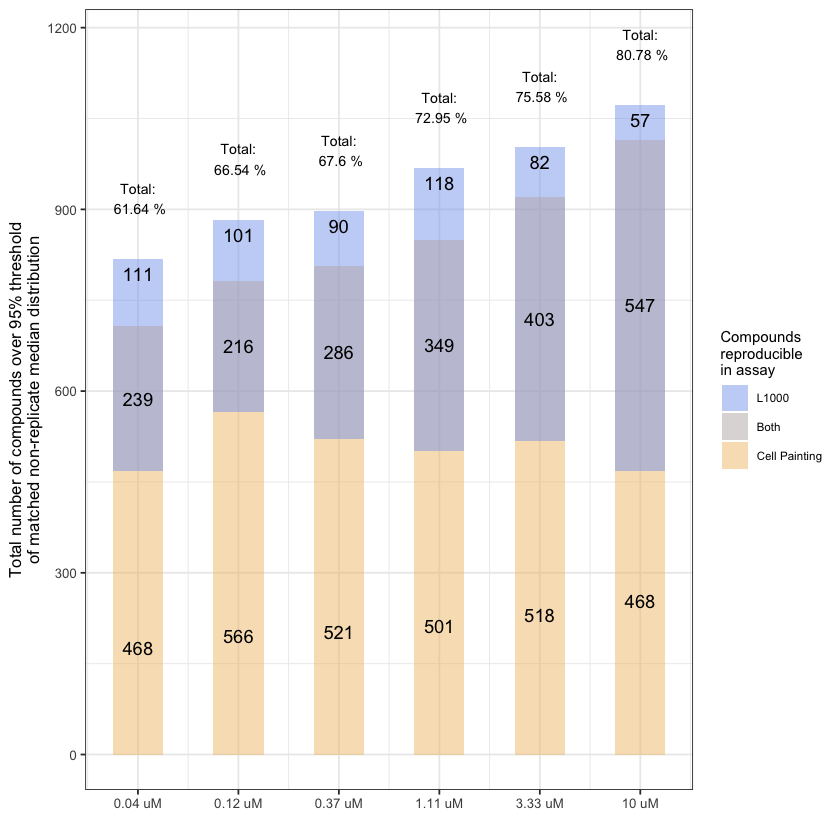

In [14]:
updated_assay_colors <- c(assay_colors, "Both" = "#BDB4B4")

panel_c_gg <- (
    ggplot(full_rect)
    + geom_rect(aes(fill = assay, ymin = ymin_bar, ymax = ymax_bar, xmin = xmin_bar, xmax = xmax_bar), alpha = 0.5)
    + geom_text(aes(x = xmin_bar + 0.5, y = label_text_y, label = unique_pass))
    + geom_text(data = num_pass_both_text, aes(x = xmin_bar + 0.5, y = label_text_y, label = num_pass_both))
    # Select only L1000 below to not duplicate text
    + geom_text(
        data = full_rect %>% dplyr::filter(assay == "L1000"),
        aes(x = xmin_bar + 0.5, y = ymax_bar + 100, label = num_pass_percentile),
        size = 3
    )
    + scale_fill_manual("Compounds\nreproducible\nin assay", values = updated_assay_colors)
    + theme_bw()
    + figure_theme
    + scale_x_continuous(labels = num_pass_both_text$dose, breaks = seq(0.5, length(num_pass_both_text$dose) * 2, 2))
    + ylab("Total number of compounds over 95% threshold\nof matched non-replicate median distribution")
    + xlab("")
    + ylim(0, max(full_rect$num_pass_total, na.rm = TRUE) + 100)

)

panel_c_gg

## Compile and save Figure 1

Warning message:
“Removed 1 rows containing missing values (geom_rect).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”
Warning message:
“Removed 1 rows containing missing values (geom_rect).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”
Warning message:
“Removed 1 rows containing missing values (geom_rect).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”


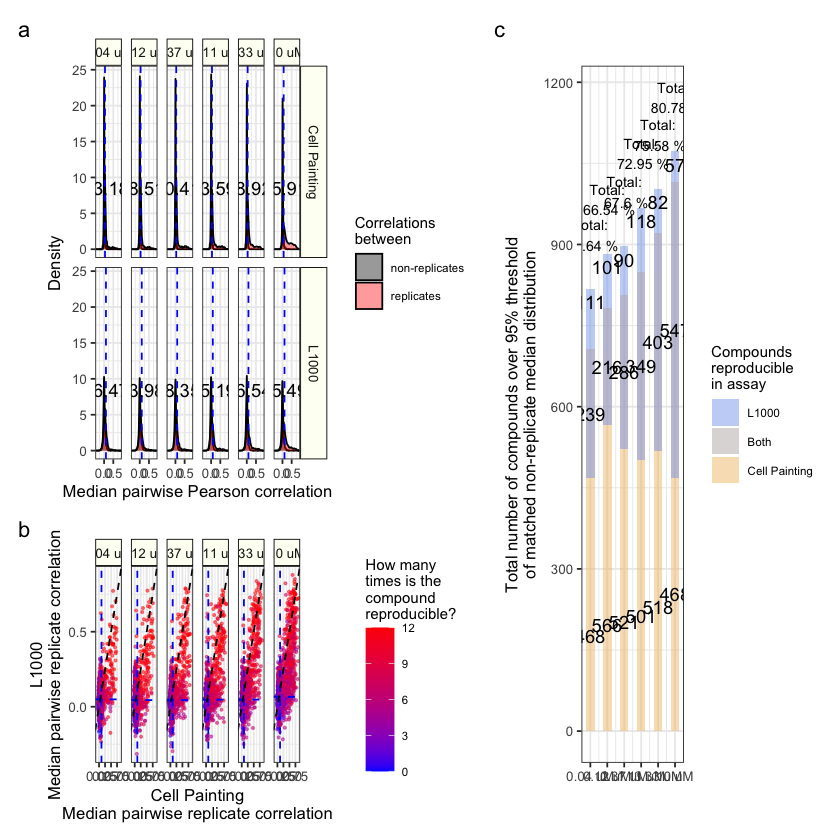

In [15]:
left_panel <- (panel_a_gg / panel_b_gg) + plot_layout(heights = c(2, 1))

figure_1_gg <- (
    ( left_panel | panel_c_gg)
    + plot_layout(widths = c(2, 1))
    + plot_annotation(tag_levels = "a")
)

for (extension in extensions) {
    output_file <- paste0(output_figure_base, extension)
    ggplot2::ggsave(output_file, figure_1_gg, width = 16, height = 6, dpi = 500)
}

figure_1_gg